In [0]:
!pip install gdal
!pip install rasterio
!pip install sentinelsat

In [0]:
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import gdal
from gdalconst import GA_ReadOnly 
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import numpy as np
from collections import Counter
from tqdm import tqdm_notebook as tqdm
IMG_SIZE=1031
import rasterio
from rasterio.plot import show
import subprocess
import os
import math
from sklearn.preprocessing import minmax_scale
from google.colab import drive
drive.mount('/content/drive')

# **GHS BUILT-UP**

**DOWNLOAD CLC REFERENCE DATA**

In [3]:
subprocess.run(['wget', 'https://land.copernicus.eu/land-files/7ac95361f9ac3cecdf37785bc183ff02dd765a16.zip'])
subprocess.run(['unzip' ,'7ac95361f9ac3cecdf37785bc183ff02dd765a16.zip'])
subprocess.run(['unzip' ,'clc2018_clc2018_v2018_20_raster100m.zip'])
subprocess.run(['gdalwarp','-co','COMPRESS=DEFLATE','-t_srs','EPSG:32632','clc2018_clc2018_v2018_20_raster100m/CLC2018_CLC2018_V2018_20.tif','europe.tif'])


CompletedProcess(args=['gdalwarp', '-co', 'COMPRESS=DEFLATE', '-t_srs', 'EPSG:32632', 'clc2018_clc2018_v2018_20_raster100m/CLC2018_CLC2018_V2018_20.tif', 'europe.tif'], returncode=0)

**STEP 1 : DATA PREPROCESSING**

In [0]:
def download_scene(file_id):
  api = SentinelAPI('uname', 'pwd',api_url='https://scihub.copernicus.eu/apihub')
  api.download(file_id)

def unzip_scene(file_name):
  subprocess.call('unzip '+file_name,shell=True)

def jp2_to_tif(input_file,output_file):
  subprocess.call('gdal_translate ' +input_file+' '+output_file,shell=True)

def clip_ref_scene(input_file,output_file):
  data=gdal.Open(input_file,GA_ReadOnly) 
  geoTransform=data.GetGeoTransform() 
  minx=geoTransform[0] 
  maxy=geoTransform[3] 
  maxx = minx + geoTransform[1] * data.RasterXSize 
  miny = maxy + geoTransform[5] * data.RasterYSize 
  subprocess.call('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff europe.tif ' +output_file, shell=True) 

def resize_scene(input_file,output_file):
  subprocess.call('gdal_translate -co QUALITY=100 -co PROGRESSIVE=ON -outsize '+str(IMG_SIZE)+' '+str(IMG_SIZE)+' -r bilinear '+input_file+' '+output_file,shell=True)



def clip_ref_scene_pop(input_file,output_file):
  data=gdal.Open(input_file,GA_ReadOnly) 
  geoTransform=data.GetGeoTransform() 
  minx=geoTransform[0] 
  maxy=geoTransform[3] 
  maxx = minx + geoTransform[1] * data.RasterXSize 
  miny = maxy + geoTransform[5] * data.RasterYSize 
  subprocess.call('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff world-population.tif ' +output_file, shell=True) 

In [5]:
#download_scene('742eb824-df10-4402-866e-0d92e8575aa4')
download_scene('cbb628b9-8399-4a24-aaeb-b5d5bdc49be0')
unzip_scene('/content/S2A_MSIL1C_20190926T105811_N0208_R094_T30TVK_20190926T130550.zip')
jp2_to_tif('/content/S2A_MSIL1C_20190926T105811_N0208_R094_T30TVK_20190926T130550.SAFE/GRANULE/L1C_T30TVK_A022256_20190926T110642/IMG_DATA/T30TVK_20190926T105811_TCI.jp2','test-full-temp.tif')
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 'test-full-temp.tif' 'test-full.tif'
clip_ref_scene('test-full.tif','test-y.tif')
resize_scene('test-full.tif','test.tif')
jp2_to_tif('/content/S2A_MSIL1C_20190926T105811_N0208_R094_T30TVK_20190926T130550.SAFE/GRANULE/L1C_T30TVK_A022256_20190926T110642/IMG_DATA/T30TVK_20190926T105811_B08.jp2','test-b8-full-temp.tif')
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 'test-b8-full-temp.tif' 'test-b8-full.tif'
clip_ref_scene('test-b8-full.tif','test-b8-y.tif')
resize_scene('test-b8-full.tif','test-b8.tif')


Downloading: 100%|██████████| 900M/900M [00:30<00:00, 29.1MB/s]
MD5 checksumming: 100%|██████████| 900M/900M [00:02<00:00, 437MB/s]


Creating output file that is 12371P x 12371L.
Processing input file test-full-temp.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12371P x 12371L.
Processing input file test-b8-full-temp.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


**DOWNLOAD GPW DATA**

In [6]:
!unzip '/content/drive/My Drive/Colab_Notebooks/gpw-v4-population-count-rev11_2015_30_sec_tif.zip'
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 '/content/gpw_v4_population_count_rev11_2015_30_sec.tif' 'world-population.tif'
clip_ref_scene_pop('test-full.tif','test-pop-full.tif')
resize_scene('test-pop-full.tif','test-pop.tif')


Archive:  /content/drive/My Drive/Colab_Notebooks/gpw-v4-population-count-rev11_2015_30_sec_tif.zip
  inflating: gpw_v4_population_count_rev11_2015_30_sec.tif  
  inflating: gpw_v4_population_count_rev11_2015_30_sec_tif_readme.txt  
Creating output file that is 31049P x 36997L.
Processing input file /content/gpw_v4_population_count_rev11_2015_30_sec.tif.
Using internal nodata values (e.g. -3.40282e+38) for image /content/gpw_v4_population_count_rev11_2015_30_sec.tif.
Copying nodata values from source /content/gpw_v4_population_count_rev11_2015_30_sec.tif to destination world-population.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
download_scene('4f07815d-5709-4b0b-8fdd-7e12c78e6546')
unzip_scene('S2A_MSIL1C_20190629T103031_N0207_R108_T32UMV_20190629T124358.zip')
jp2_to_tif('/content/S2A_MSIL1C_20190629T103031_N0207_R108_T32UMV_20190629T124358.SAFE/GRANULE/L1C_T32UMV_A020983_20190629T103537/IMG_DATA/T32UMV_20190629T103031_TCI.jp2','s1-full.tif')
clip_ref_scene('s1-full.tif','s1-y.tif')
resize_scene('s1-full.tif','s1.tif')
jp2_to_tif('/content/S2A_MSIL1C_20190629T103031_N0207_R108_T32UMV_20190629T124358.SAFE/GRANULE/L1C_T32UMV_A020983_20190629T103537/IMG_DATA/T32UMV_20190629T103031_B08.jp2','s1-b8-full.tif')
clip_ref_scene('s1-b8-full.tif','s1-b8-y.tif')
resize_scene('s1-b8-full.tif','s1-b8.tif')

Downloading: 100%|██████████| 854M/854M [00:28<00:00, 30.3MB/s]
MD5 checksumming: 100%|██████████| 854M/854M [00:01<00:00, 431MB/s]


In [8]:
download_scene('03cf3314-1b05-46f1-af1b-cee2652edf2b')
unzip_scene('S2B_MSIL1C_20190724T103029_N0208_R108_T32UMV_20190724T122822.zip')
jp2_to_tif('/content/S2B_MSIL1C_20190724T103029_N0208_R108_T32UMV_20190724T122822.SAFE/GRANULE/L1C_T32UMV_A012432_20190724T103030/IMG_DATA/T32UMV_20190724T103029_TCI.jp2','s2-full.tif')
clip_ref_scene('s2-full.tif','s2-y.tif')
resize_scene('s2-full.tif','s2.tif')
jp2_to_tif('/content/S2B_MSIL1C_20190724T103029_N0208_R108_T32UMV_20190724T122822.SAFE/GRANULE/L1C_T32UMV_A012432_20190724T103030/IMG_DATA/T32UMV_20190724T103029_B08.jp2','s2-b8-full.tif')
clip_ref_scene('s2-b8-full.tif','s2-b8-y.tif')
resize_scene('s2-b8-full.tif','s2-b8.tif')

Downloading: 100%|██████████| 840M/840M [00:27<00:00, 30.1MB/s]
MD5 checksumming: 100%|██████████| 840M/840M [00:01<00:00, 437MB/s]


In [9]:
download_scene('67a87302-2ff4-4c81-9e5e-792367578f6d')
unzip_scene('S2B_MSIL1C_20190921T105739_N0208_R094_T30UYC_20190921T131721.zip')
jp2_to_tif('/content/S2B_MSIL1C_20190921T105739_N0208_R094_T30UYC_20190921T131721.SAFE/GRANULE/L1C_T30UYC_A013276_20190921T110218/IMG_DATA/T30UYC_20190921T105739_TCI.jp2','s3-full-temp.tif')
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 's3-full-temp.tif' 's3-full.tif'
clip_ref_scene('s3-full.tif','s3-y.tif')
resize_scene('s3-full.tif','s3.tif')
jp2_to_tif('/content/S2B_MSIL1C_20190921T105739_N0208_R094_T30UYC_20190921T131721.SAFE/GRANULE/L1C_T30UYC_A013276_20190921T110218/IMG_DATA/T30UYC_20190921T105739_B08.jp2','s3-b8-full-temp.tif')
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 's3-b8-full-temp.tif' 's3-b8-full.tif'
clip_ref_scene('s3-b8-full.tif','s3-b8-y.tif')
resize_scene('s3-b8-full.tif','s3-b8.tif')

Downloading: 100%|██████████| 818M/818M [00:27<00:00, 30.0MB/s]
MD5 checksumming: 100%|██████████| 818M/818M [00:01<00:00, 437MB/s]


Creating output file that is 12634P x 12634L.
Processing input file s3-full-temp.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12634P x 12634L.
Processing input file s3-b8-full-temp.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
download_scene('c04d2ba0-4880-4dcf-a733-879231478aa3')
unzip_scene('S2B_MSIL1C_20190724T103029_N0208_R108_T31TGN_20190724T122822.zip')
jp2_to_tif('/content/S2B_MSIL1C_20190724T103029_N0208_R108_T31TGN_20190724T122822.SAFE/GRANULE/L1C_T31TGN_A012432_20190724T103030/IMG_DATA/T31TGN_20190724T103029_TCI.jp2','s4-full-temp.tif')
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 's4-full-temp.tif' 's4-full.tif'
clip_ref_scene('s4-full.tif','s4-y.tif')
resize_scene('s4-full.tif','s4.tif')
jp2_to_tif('/content/S2B_MSIL1C_20190724T103029_N0208_R108_T31TGN_20190724T122822.SAFE/GRANULE/L1C_T31TGN_A012432_20190724T103030/IMG_DATA/T31TGN_20190724T103029_B08.jp2','s4-b8-full-temp.tif')
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 's4-b8-full-temp.tif' 's4-b8-full.tif'
clip_ref_scene('s4-b8-full.tif','s4-b8-y.tif')
resize_scene('s4-b8-full.tif','s4-b8.tif')

Downloading: 100%|██████████| 824M/824M [00:27<00:00, 30.0MB/s]
MD5 checksumming: 100%|██████████| 824M/824M [00:01<00:00, 435MB/s]


Creating output file that is 11792P x 11792L.
Processing input file s4-full-temp.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 11792P x 11792L.
Processing input file s4-b8-full-temp.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
download_scene('4557d038-7f7e-4356-b410-5c6e7d741e7f')
unzip_scene('/content/S2A_MSIL1C_20190904T102021_N0208_R065_T32TNT_20190904T123501.zip')
jp2_to_tif('/content/S2A_MSIL1C_20190904T102021_N0208_R065_T32TNT_20190904T123501.SAFE/GRANULE/L1C_T32TNT_A021941_20190904T102045/IMG_DATA/T32TNT_20190904T102021_TCI.jp2','s5-full.tif')
clip_ref_scene('s5-full.tif','s5-y.tif')
resize_scene('s5-full.tif','s5.tif')
jp2_to_tif('/content/S2A_MSIL1C_20190904T102021_N0208_R065_T32TNT_20190904T123501.SAFE/GRANULE/L1C_T32TNT_A021941_20190904T102045/IMG_DATA/T32TNT_20190904T102021_B08.jp2','s5-b8-full.tif')
clip_ref_scene('s5-b8-full.tif','s5-b8-y.tif')
resize_scene('s5-b8-full.tif','s5-b8.tif')

Downloading: 100%|██████████| 847M/847M [00:28<00:00, 30.0MB/s]
MD5 checksumming: 100%|██████████| 847M/847M [00:01<00:00, 431MB/s]


In [12]:
download_scene('336a6ef0-784a-4a90-8333-02ed7ae93b85')
unzip_scene('/content/S2B_MSIL1C_20190913T100029_N0208_R122_T33TVJ_20190913T134222.zip')
jp2_to_tif('/content/S2B_MSIL1C_20190913T100029_N0208_R122_T33TVJ_20190913T134222.SAFE/GRANULE/L1C_T33TVJ_A013161_20190913T100548/IMG_DATA/T33TVJ_20190913T100029_TCI.jp2','s6-full-temp.tif')
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 's6-full-temp.tif' 's6-full.tif'
clip_ref_scene('s6-full.tif','s6-y.tif')
resize_scene('s6-full.tif','s6.tif')
jp2_to_tif('/content/S2B_MSIL1C_20190913T100029_N0208_R122_T33TVJ_20190913T134222.SAFE/GRANULE/L1C_T33TVJ_A013161_20190913T100548/IMG_DATA/T33TVJ_20190913T100029_B08.jp2','s6-b8-full-temp.tif')
!gdalwarp -co  COMPRESS=DEFLATE -t_srs EPSG:32632 's6-b8-full-temp.tif' 's6-b8-full.tif'
clip_ref_scene('s6-b8-full.tif','s6-b8-y.tif')
resize_scene('s6-b8-full.tif','s6-b8.tif')

Downloading: 100%|██████████| 555M/555M [00:18<00:00, 29.5MB/s]
MD5 checksumming: 100%|██████████| 555M/555M [00:01<00:00, 435MB/s]


Creating output file that is 11747P x 11747L.
Processing input file s6-full-temp.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 11747P x 11747L.
Processing input file s6-b8-full-temp.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


**VISUALIZE TEST SET - MADRID REGION - SPAIN**

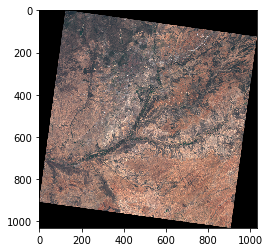

In [176]:
dataset = rasterio.open('test.tif')
show(dataset.read([1,2,3]))

In [0]:
tif1=gdal.Open('s1.tif')
s1r = tif1.GetRasterBand(1).ReadAsArray()
s1g = tif1.GetRasterBand(2).ReadAsArray()
s1b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s1-b8.tif')
s1b8=tif1.GetRasterBand(1).ReadAsArray()


tif1=gdal.Open('s2.tif')
s2r = tif1.GetRasterBand(1).ReadAsArray()
s2g = tif1.GetRasterBand(2).ReadAsArray()
s2b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s2-b8.tif')
s2b8=tif1.GetRasterBand(1).ReadAsArray()


tif1=gdal.Open('s3.tif')
s3r = tif1.GetRasterBand(1).ReadAsArray()
s3g = tif1.GetRasterBand(2).ReadAsArray()
s3b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s3-b8.tif')
s3b8=tif1.GetRasterBand(1).ReadAsArray()


tif1=gdal.Open('s4.tif')
s4r = tif1.GetRasterBand(1).ReadAsArray()
s4g = tif1.GetRasterBand(2).ReadAsArray()
s4b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s4-b8.tif')
s4b8=tif1.GetRasterBand(1).ReadAsArray()


tif1=gdal.Open('s5.tif')
s5r = tif1.GetRasterBand(1).ReadAsArray()
s5g = tif1.GetRasterBand(2).ReadAsArray()
s5b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s5-b8.tif')
s5b8=tif1.GetRasterBand(1).ReadAsArray()


tif1=gdal.Open('s6.tif')
s6r = tif1.GetRasterBand(1).ReadAsArray()
s6g = tif1.GetRasterBand(2).ReadAsArray()
s6b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s6-b8.tif')
s6b8=tif1.GetRasterBand(1).ReadAsArray()


In [0]:
tif2=gdal.Open('test-y.tif')
Y_raster_test= tif2.GetRasterBand(1).ReadAsArray()
Y_raster_test[Y_raster_test < 100] = 999
Y_raster_test[(Y_raster_test > 100)&(Y_raster_test <= 150)] = 0
Y_raster_test[Y_raster_test > 150] = 255

In [179]:
tif2=gdal.Open('s1-y.tif')
Y_raster_s1 = tif2.GetRasterBand(1).ReadAsArray()
Y_raster_s1[Y_raster_s1 < 100] = 999
Y_raster_s1[(Y_raster_s1 > 100)&(Y_raster_s1 <= 150)] = 0
Y_raster_s1[Y_raster_s1 > 150] = 255
Y_list=Y_raster_s1.flatten().tolist()
print(len(Y_list))

1062961


In [180]:
tif2=gdal.Open('s2-y.tif')
Y_raster_s2 = tif2.GetRasterBand(1).ReadAsArray()
print(np.unique(Y_raster_s2))
Y_raster_s2[Y_raster_s2 < 100] = 999
Y_raster_s2[(Y_raster_s2 > 100)&(Y_raster_s2 <= 150)] = 0
Y_raster_s2[Y_raster_s2 > 150] = 255

Y_list=Y_list+(Y_raster_s2.flatten().tolist())

[111 112 121 122 123 124 131 132 133 141 142 211 221 222 231 242 243 311
 312 313 321 322 324 411 412 511 512]


In [181]:
tif2=gdal.Open('s3-y.tif')
Y_raster_s3 = tif2.GetRasterBand(1).ReadAsArray()
print(np.unique(Y_raster_s3))
Y_raster_s3[Y_raster_s3 < 100] = 999
Y_raster_s3[(Y_raster_s3 > 100)&(Y_raster_s3 <= 150)] = 0
Y_raster_s3[Y_raster_s3 > 150] = 255

Y_list=Y_list+(Y_raster_s3.flatten().tolist())

[-32768    111    112    121    122    123    124    131    132    133
    141    142    211    222    231    242    243    311    312    313
    321    322    324    331    411    421    423    511    512    522
    523]


In [182]:
tif2=gdal.Open('s4-y.tif')
Y_raster_s4 = tif2.GetRasterBand(1).ReadAsArray()
print(np.unique(Y_raster_s4))
Y_raster_s4[Y_raster_s4 < 100] = 999
Y_raster_s4[(Y_raster_s4 > 100)&(Y_raster_s4 <= 150)] = 0
Y_raster_s4[Y_raster_s4 > 150] = 255
 
Y_list=Y_list+(Y_raster_s4.flatten().tolist())

print(len(Y_list))

[111 112 121 122 124 131 132 133 141 142 211 221 222 231 242 243 311 312
 313 321 322 324 411 412 511 512]
4769852


In [183]:
tif2=gdal.Open('s5-y.tif')
Y_raster_s5 = tif2.GetRasterBand(1).ReadAsArray()
print(np.unique(Y_raster_s5))
Y_raster_s5[Y_raster_s5 < 100] = 999
Y_raster_s5[(Y_raster_s5 > 100)&(Y_raster_s5 <= 150)] = 0
Y_raster_s5[Y_raster_s5 > 150] = 255
 
Y_list=Y_list+(Y_raster_s5.flatten().tolist())

[111 112 121 122 124 131 132 133 141 142 211 221 222 231 242 243 311 312
 313 321 322 324 331 332 333 335 411 412 511 512]


In [184]:
tif2=gdal.Open('s6-y.tif')
Y_raster_s6 = tif2.GetRasterBand(1).ReadAsArray()
print(np.unique(Y_raster_s6))
Y_raster_s6[Y_raster_s6 < 100] = 999
Y_raster_s6[(Y_raster_s6 > 100)&(Y_raster_s6 <= 150)] = 0
Y_raster_s6[Y_raster_s6 > 150] = 255
 
Y_list=Y_list+(Y_raster_s6.flatten().tolist())

[-32768    112    121    122    123    142    211    221    223    231
    242    243    311    312    313    321    323    324    331    333
    421    422    512    523]


In [185]:
print(np.unique(Y_list))

[  0 255]


In [0]:
#CONVERT RGB BANDS AS INPUT FEATURE SEQUENCES
#QUANTIZATION

rband_list=s1r.flatten().tolist()
rband_list=rband_list+(s2r.flatten().tolist())
rband_list=rband_list+(s3r.flatten().tolist())
rband_list=rband_list+(s4r.flatten().tolist())
rband_list=rband_list+(s5r.flatten().tolist())
rband_list=rband_list+(s6r.flatten().tolist())



gband_list=s1g.flatten().tolist()
gband_list=gband_list+(s2g.flatten().tolist())
gband_list=gband_list+(s3g.flatten().tolist())
gband_list=gband_list+(s4g.flatten().tolist())
gband_list=gband_list+(s5g.flatten().tolist())
gband_list=gband_list+(s6g.flatten().tolist())




bband_list=s1b.flatten().tolist()
bband_list=bband_list+(s2b.flatten().tolist())
bband_list=bband_list+(s3b.flatten().tolist())
bband_list=bband_list+(s4b.flatten().tolist())
bband_list=bband_list+(s5b.flatten().tolist())
bband_list=bband_list+(s6b.flatten().tolist())



band8_list=s1b8.flatten().tolist()
band8_list=band8_list+(s2b8.flatten().tolist())
band8_list=band8_list+(s3b8.flatten().tolist())
band8_list=band8_list+(s4b8.flatten().tolist())
band8_list=band8_list+(s5b8.flatten().tolist())
band8_list=band8_list+(s6b8.flatten().tolist())


q1=max(rband_list)/16
q2=max(gband_list)/16
q3=max(bband_list)/16
q4=max(band8_list)/18


rband_list = [round(math.floor(x+0.5)/q1) for x in rband_list]
gband_list = [round(math.floor(x+0.5)/q2) for x in gband_list]
bband_list = [round(math.floor(x+0.5)/q3) for x in bband_list]
band8_list = [round(math.floor(x+0.5)/q4) for x in band8_list]



In [187]:
print(len(rband_list))

6377766


***SEQUENCE LIST AND ANTECEDENT-CONSEQUENT LIST(X->Y)***

In [0]:
sequences_list=[]
ante_consq_list=[]

In [189]:
for i in tqdm(range(len(rband_list))):
  sequences_list.append((rband_list[i],gband_list[i],bband_list[i],band8_list[i]))
  ante_consq_list.append((rband_list[i],gband_list[i],bband_list[i],band8_list[i],Y_list[i]))

print('BUILDING DATA DONE')



BUILDING DATA DONE


***RANDOM EXAMPLE - DATA STRUCTURE (R, G, B, B8, CLASS_LABEL)***

In [190]:
print ((ante_consq_list[56]))

(3, 4, 4, 4, 255)


***FIND UNIQUE SEQUENCES(X-cap) AND COUNT***

In [191]:
print('UNIQUE SEQUENCES COUNT: ')
print(len(list(set(sequences_list))))
unique_X_sequences=list(set(sequences_list))

UNIQUE SEQUENCES COUNT: 
909




---



***STEP 2:***

*   ***ASSOCIATION ANALYSIS***
*   ***EVIDENCE BASED NORMALIZED DIFFERENTIAL INDEX(ENDI) MEASURE***




***HELPER FUNCTIONS:***

In [0]:
#ONE VARIATION OF ENDI INTERESTINGNESS MEASURE
def calculate_ENDI(positive,negative):
  if (positive==0) and (negative==0) : return 0
  return (positive-negative)/(positive+negative)

In [0]:
#POSITIVE EVIDENCES
def positive_count(sequence,class_name):
  item = list(sequence)
  item.append(class_name)
  c=counter[tuple(item)]
  return c


#NEGATIVE EVIDENCES
def negative_count(sequence, class_list):
  negative_classcount=0
  for c in  class_list:
    item = list(sequence)
    item.append(c)
    negative_classcount=negative_classcount+counter[tuple(item)]

  return negative_classcount



In [0]:
#COUNT FREQUENCIES OF EACH UNIQUE SEQUENCE
counter=Counter(ante_consq_list)

***CALCULATE ENDI MEASURE FOR ALL THE CLASSES PER SEQUENCE DATA***

In [195]:
#GENERATE A DICTIONARY OF THE FORM : {(unique sequence) : [ENDI MEASURE-CLASS 0, ENDI MEASURE-CLASS 1]}
ENDI_table_dictionary={}

for i in tqdm(range(len(unique_X_sequences))):
  seq=unique_X_sequences[i]
  ENDI_class_0=calculate_ENDI(positive_count(seq,0),negative_count(seq,[255]))
  ENDI_class_1=calculate_ENDI(positive_count(seq,255),negative_count(seq,[0]))
  ENDI_table_dictionary[seq]=[ENDI_class_0,ENDI_class_1]

print('BUILDING DICTIONARY DONE')

#PRINT RANDOM DATA POINT
#print(ENDI_table_dictionary[unique_X_sequences[5000]])



BUILDING DICTIONARY DONE




---



***STEP 3 : CLASSIFICATION AND VISUALIZATION***

In [0]:
def classification(file_name,band8filename):
          new_image=gdal.Open(file_name)
          rband_new = new_image.GetRasterBand(1).ReadAsArray()
          gband_new = new_image.GetRasterBand(2).ReadAsArray()
          bband_new = new_image.GetRasterBand(3).ReadAsArray()
          tif1=gdal.Open(band8filename)
          band8_new=tif1.GetRasterBand(1).ReadAsArray()

          rband_list_new=rband_new.flatten().tolist()
          gband_list_new=gband_new.flatten().tolist()
          bband_list_new=bband_new.flatten().tolist()
          band8_list_new=band8_new.flatten().tolist()

          q1=max(rband_list_new)/16
          q2=max(gband_list_new)/16
          q3=max(bband_list_new)/16
          q4=max(band8_list_new)/18

          rband_list_new = [round(math.floor(x+0.5)/q1) for x in rband_list_new]
          gband_list_new = [round(math.floor(x+0.5)/q2) for x in gband_list_new]
          bband_list_new = [round(math.floor(x+0.5)/q3) for x in bband_list_new]
          band8_list_new = [round(math.floor(x+0.5)/q4) for x in band8_list_new]


          final_pred_list=[]
          final_confidence_list=[]

          for i in tqdm(range(len(rband_list_new))):

            if ((rband_list_new[i],gband_list_new[i],bband_list_new[i],band8_list_new[i])) in ENDI_table_dictionary:
                  ENDI_vals=ENDI_table_dictionary[(rband_list_new[i],gband_list_new[i],bband_list_new[i],band8_list_new[i])]
                  max_val = max(ENDI_vals)
                  index_max = ENDI_vals.index(max_val)
                  final_pred_list.append(index_max)
                  final_confidence_list.append(ENDI_vals[0])   
            else:
              final_pred_list.append(1)
              final_confidence_list.append(-1)

          final_confidence_list_scaled = minmax_scale(final_confidence_list, feature_range=(0,100))
          return final_pred_list,final_confidence_list_scaled



In [0]:
def visualization(any_list,size,title,outputfile,colormap):
  numpy_array=np.asarray(any_list)
  #numpy_array[numpy_array == 1] = 255
  final_image_array=numpy_array.reshape((size,size))
  fig, ax = plt.subplots()
  ax.set_title(title)
  img = ax.imshow(final_image_array,cmap=plt.get_cmap(colormap))
  fig.colorbar(img, ax=ax)
  fig.savefig(outputfile+'.png')
  cv2.imwrite(outputfile+".tif", final_image_array)

In [0]:
def metrics(y_actual, y_pred_original):
    numpy_array=np.asarray(y_pred_original)
    numpy_array[numpy_array == 1] = 255
    y_pred=numpy_array.tolist()
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in tqdm(range(len(y_pred))):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN



---



**VISUALIZATION OF RESULTS AND METRICS - MADRID AREA(SPAIN)**

1) MADRID CLASSIFICATION RESULTS

In [199]:
prediction_list,confidence_list=classification('test.tif','test-b8.tif')


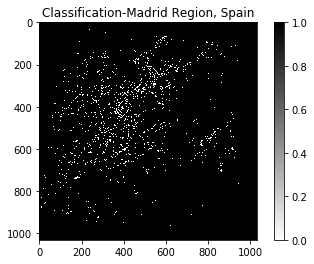

In [200]:
visualization(prediction_list,  IMG_SIZE, 'Classification-Madrid Region, Spain','predictions-madrid',colormap='binary')

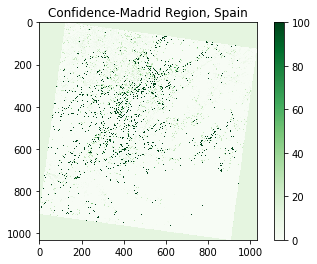

In [201]:
visualization(confidence_list,  IMG_SIZE,'Confidence-Madrid Region, Spain','confidence-madrid',colormap='Greens')

In [202]:
m=metrics(Y_raster_test.flatten().tolist(),prediction_list)

In [0]:
unique, counts = np.unique(Y_raster_test.flatten().tolist(), return_counts=True)

In [204]:
for i in range(0,2):
  TP=m[1][i]
  FP=m[2][i]
  TN=m[3][i]
  FN=m[4][i]
  P=counts[i]
  N=len(Y_list)-P
  TPR=TP/P
  TNR=TN/N
  bal_measure = (TPR+TNR)/2
  inf_accuracy=TPR-TNR
  print('BALANCED ACCURACY FOR CLASS '+str(i)+" is "+ str(bal_measure))
  print('INFORMEDNESS FOR CLASS '+str(i)+" is "+str(inf_accuracy))


BALANCED ACCURACY FOR CLASS 0 is 0.08182210162870895
INFORMEDNESS FOR CLASS 0 is -0.10021403591198473
BALANCED ACCURACY FOR CLASS 1 is 0.3643016883644962
INFORMEDNESS FOR CLASS 1 is 0.7271509196183651


2)ORIGINAL RGB IMAGE

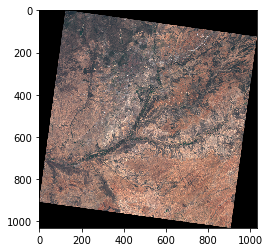

In [205]:
dataset = rasterio.open('test.tif')
show(dataset.read([1,2,3]))



---



# **GHS-POP**

Text(0.5, 1.0, 'GHS POP')

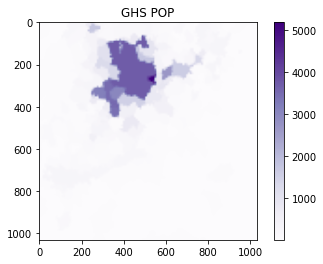

In [206]:
pop1=gdal.Open('test-pop.tif')
pop2d = pop1.GetRasterBand(1).ReadAsArray()
pop2d[pop2d < 0] = 0
fig, ax = plt.subplots()
img = ax.imshow((pop2d),cmap=plt.get_cmap('Purples'))
fig.colorbar(img, ax=ax)
ax.set_title('GHS POP')



---



# **GHS S-MOD**

In [0]:
def classify_urban_area(i,j,d,arr):
  n = arr[i-d:i+d+1, j-d:j+d+1].flatten()
  return n

In [0]:
confidence2d=np.asarray(confidence_list).reshape((IMG_SIZE,IMG_SIZE))

CLASSIFY URBAN CENTRE, URBAN CLUSTER, RURAL AREA AND OTHER REGIONS

In [227]:
urban_array=np.zeros((IMG_SIZE, IMG_SIZE))

for ix,iy in tqdm(np.ndindex(pop2d.shape)):
    popcellvalue=pop2d[ix,iy]
    confidencecellvalue=confidence2d[ix,iy]

    if((popcellvalue>1500 or confidencecellvalue>50) and (np.sum(classify_urban_area(ix,iy,2,pop2d))>50000)):
      urban_array[ix,iy]=3
    elif (popcellvalue>300 and (np.sum(classify_urban_area(ix,iy,8,pop2d))>5000)):
      urban_array[ix,iy]=2
    elif(popcellvalue>1 and (np.sum(classify_urban_area(ix,iy,3,pop2d))<5000)):
      urban_array[ix,iy]=1

Text(0.5, 1.0, 'GHS-SMOD')

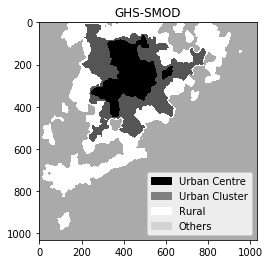

In [228]:
from matplotlib import colors
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
black_patch = mpatches.Patch(color='black', label='Urban Centre')
dark_grey_patch=mpatches.Patch(color='grey', label='Urban Cluster')
grey_patch = mpatches.Patch(color='lightgray', label='Others')
white_patch = mpatches.Patch(color='white', label='Rural')

ax.legend(handles=[black_patch,dark_grey_patch,white_patch, grey_patch], loc='lower right')
img = ax.imshow(urban_array,cmap=plt.get_cmap('binary'))
ax.set_title('GHS-SMOD')



---

